## Statistical Inference on Premier League 2021-2022 dataset ###

### Sources:
-  Databases from Premier League seasons found in  https://www.excel4soccer.com/ and https://data.world/datasets/premier-league

We will propose 3 different research questions for which different methods of statistical inference, applied to our dataset, will be used to answer them. These questions are of interest because they will debunk existing soccer myths and preconceptions and they will provide valueble information for placing educated bets on your favourite teams.


For the entire inferencial study a ignificance level of 5% will be established, which defines the probability of making an error of Type I (rejecting Null hypothesis when its true).

## 0. Load libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, sem, norm
from numpy import sqrt 
import seaborn as sns



%matplotlib inline

import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import wilcoxon, ttest_1samp, ttest_rel, mannwhitneyu
from scipy.stats import chi2_contingency, chi2
from bioinfokit.analys import stat


## 1) Is home field advantage a real thing? ##

- H0: there is no advantage difference between home and away teams
- H1: win rates of home team are greater than win rate of away team

Two types of tests are performed:
   - One sample one sided t-test using the win rate difference between away and home matches means. This is equivalent to a paired t-test between the home teams and the away teams. 
   
$$H_0: u_{\text{diff}} = 0 \quad\text{vs}\quad H_1: u_{\text{diff}}> 0$$


In [40]:
# Load the data set into a pandas dataframe

league = pd.read_csv('./projectdata/league_table.csv',sep=",",decimal='.')
team = pd.read_csv('./projectdata/teamStats.csv',sep=",",decimal='.')
stats = pd.read_csv('./projectdata/PREMIER_LEAGUE_STATS_2022_20223.csv',sep=",",decimal='.')
data = pd.read_csv('./projectdata/PREMIER_LEAGUE_NEW.csv',sep=",",decimal='.')


premier_2013_2014 = pd.read_csv('./projectdata/2013-2014.csv',sep=",",decimal='.')
premier_2015_2016 = pd.read_csv('./projectdata/2015-2016.csv',sep=",",decimal='.')
premier_2016_2017 = pd.read_csv('./projectdata/2016-2017.csv',sep=",",decimal='.')
premier_2017_2018 = pd.read_csv('./projectdata/2017-2018.csv',sep=",",decimal='.')
premier_2018_2019 = pd.read_csv('./projectdata/2018-2019.csv',sep=",",decimal='.')
premier_2021_2022 = pd.read_csv('./projectdata/2021-2022.csv',sep=",",decimal='.')

## Exploratory Analysis and Normality Test ##

In [41]:
# Visual inspection of the distribution of the data and the presence of outliers
def visual_normality_test(x1, color, bins = 20):
        
    mu1 = np.mean(x1)
    sigma1 = np.std(x1, ddof = 1) # unbiased std

    plt.figure(figsize = (20,4))

    ax1 = plt.subplot(2,3,1)
    ax1.hist(x1,bins=bins, density = True, color = color)
    x1_axis = np.linspace(mu1 - 4*sigma1, mu1 + 4*sigma1, 100)
    ax1.plot(x1_axis,norm.pdf(x1_axis, mu1, sigma1),'r',linewidth=2)
    ax1.set_title('Normalized histogram home wins')
    
    ax2 = plt.subplot(2,3,2)
    ax2.boxplot(x1)
    ax2.set_title('Boxplot')
    
    ax3 = plt.subplot(2,3,3)
    sm.qqplot(x1, line='s', ax=ax3)
    ax3.set_title('QQ Plot')
    
    plt.show()
    

# Shapiro-Wilk (SW) test for normally

def shapiro_wilk_test (x):
    sw_statistic, p_value = shapiro(x)
    print('SW Statistic:', sw_statistic, '\t p-value:', p_value)

    if p_value > 0.05: 
        print('Looks like a normal distribution, p-value:', p_value)
    else:
        print('Does not lool like a normal distribution, p-value:', p_value)


,Home Wins,Away Wins,Draws
2013_2014 season,179,123,78
2015_2016 season,157,116,107
2016_2017 season,187,109,84
2017_2018 season,173,108,99
2018_2019 season,181,128,71
2021_2022 season,163,129,88


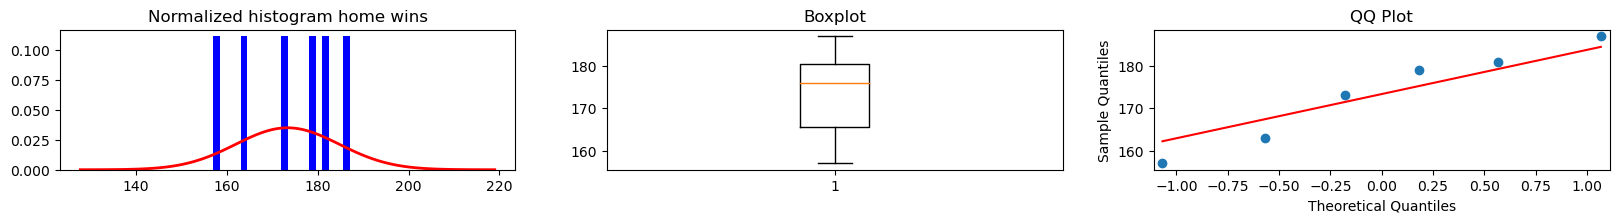

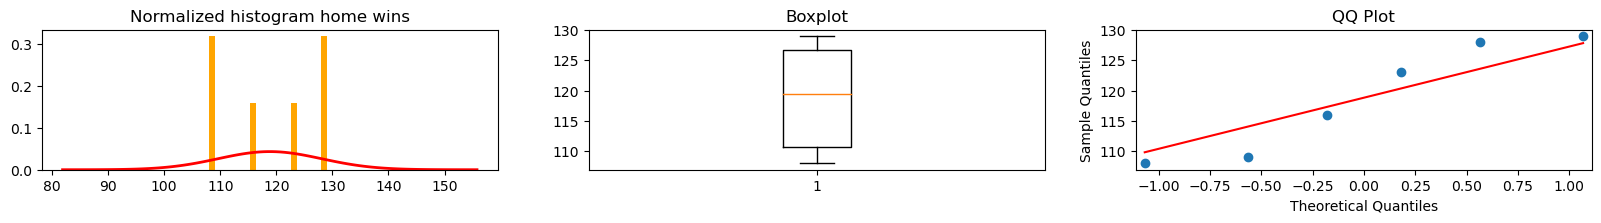

SW Statistic: 0.949729323387146 	 p-value: 0.7380892634391785
Looks like a normal distribution, p-value: 0.7380892634391785
SW Statistic: 0.8866376876831055 	 p-value: 0.30094367265701294
Looks like a normal distribution, p-value: 0.30094367265701294


In [42]:
data = [[(premier_2013_2014["FTR"]=="H").sum(), (premier_2013_2014["FTR"]=="A").sum(), (premier_2013_2014["FTR"]=="D").sum()], [(premier_2015_2016["FTR"]=="H").sum(), (premier_2015_2016["FTR"]=="A").sum(), (premier_2015_2016["FTR"]=="D").sum()], [(premier_2016_2017["FTR"]=="H").sum(), (premier_2016_2017["FTR"]=="A").sum(), (premier_2016_2017["FTR"]=="D").sum()], [(premier_2017_2018["FTR"]=="H").sum(), (premier_2017_2018["FTR"]=="A").sum(), (premier_2017_2018["FTR"]=="D").sum()], [(premier_2018_2019["FTR"]=="H").sum(), (premier_2018_2019["FTR"]=="A").sum(), (premier_2018_2019["FTR"]=="D").sum()], [(premier_2021_2022["FTR"]=="H").sum(), (premier_2021_2022["FTR"]=="A").sum(), (premier_2021_2022["FTR"]=="D").sum()]]
dataframe = pd.DataFrame(data, columns=['Home Wins', 'Away Wins', 'Draws'])
dataframe.index = ["2013_2014 season", "2015_2016 season", "2016_2017 season", "2017_2018 season", "2018_2019 season", "2021_2022 season"]
display(dataframe)

home_wins = dataframe['Home Wins'].values
away_wins = dataframe['Away Wins'].values
draws = dataframe['Draws'].values

visual_normality_test(home_wins, 'blue')
visual_normality_test(away_wins, 'orange')

shapiro_wilk_test(home_wins)
shapiro_wilk_test(away_wins)

From this we get that both home wins and away wins follow a normal distribution and therefore we can apply a parametric test

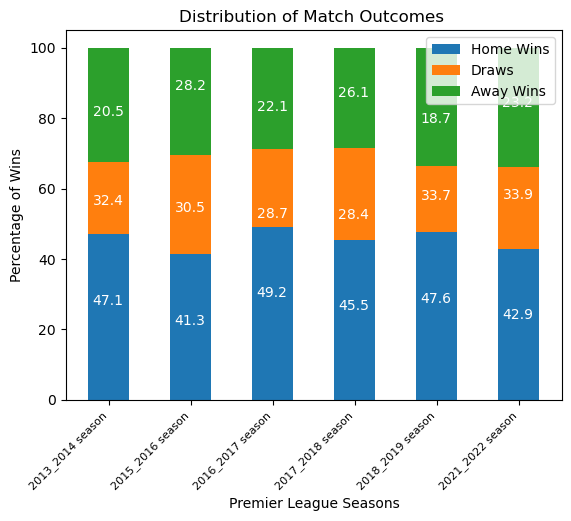

In [43]:
# Staked bar plot of the home, away and draw ratios per season

# Data for the stacked bars
categories = ["2013_2014 season", "2015_2016 season", "2016_2017 season", "2017_2018 season", "2018_2019 season", "2021_2022 season"]
total = dataframe.iloc[0].sum()
data = np.array([home_wins, draws, away_wins])/total * 100  # Values for the groups

# Plotting the stacked bars
fig, ax = plt.subplots()
bar_width = 0.5
bar_positions = range(len(categories))
ax.bar(bar_positions, data[0], width=bar_width, label='Home Wins')
ax.bar(bar_positions, data[1], width=bar_width, bottom=data[0], label='Draws')
ax.bar(bar_positions, data[2], width=bar_width, bottom=[i+j for i, j in zip(data[0], data[1])], label='Away Wins')

# Customize the plot
ax.set_xlabel('Premier League Seasons')
ax.set_ylabel('Percentage of Wins')
ax.set_title('Distribution of Match Outcomes ')

ax.set_xticks(bar_positions)
ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=8)

plt.legend(loc="upper right")

# write values inside bar segments
r = [0, 1, 2, 3, 4, 5]
for a,b in zip(r, data[0]):
    plt.text(a - 0.20, b - 20, str(round(b, 1)), color = 'white', size = '10')
    
for a,b in zip(r, data[1]):
    plt.text(a - 0.20, b + 60, str(round(b, 1)), color = 'white', size = '10')
    
for a,b in zip(r, data[2]):
    plt.text(a - 0.20, b + 23, str(round(b, 1)), color = 'white', size = '10')
        
# Show the plot
plt.show()

STAKED BAR PLOT OF HOME, AWAY AND DRAW PERCENTAGES PER SEASON

### T-test with mean difference ###

In [44]:
# 𝐻0:𝑢diff=0 vs 𝐻1:𝑢diff>0

home_wins = dataframe['Home Wins'].values
away_wins = dataframe['Away Wins'].values

u = home_wins.mean()
u0 = away_wins.mean()
alpha = 0.05

diff = home_wins - away_wins
u_diff = diff.mean()
n = len(diff)

t_statistic = diff.mean()/sem(diff)
p_value = 2*t(df=n-1).cdf(-np.abs(t_statistic))

print('The p-value is:',  p_value, 'and hence', end = " ")
if p_value < 0.05:
    print('we reject the null hypothesis H0')
else:
    print('we accept the null hypothesis H0')

The p-value is: 0.00039672692360707214 and hence we reject the null hypothesis H0


## 2) Does European competition affect national performance? ##

HYPOTHESIS TESTING:
- H0: THE PERFORMANCE IN THE NATIONAL COMPETITIONS IS NOT AFFECTED BY PARTICIPATING IN INTERNATIONAL COMPETITIONS
- H1: THE PERFORMANCE IN THE NATIONAL COMPETITION IS AFFECTED BY PARTICIPATION IN INTERNATIONAL COMPETITIONS

In [45]:
# LOAD THE DATA FROM BOTH DATABASES THAT WILL BE USED IN THIS HYPOTHESIS TESTING
df1 = pd.read_csv('./projectdata/GENERAL_ENGLISH_GAMES.csv')   #2021-2022 SEASON
df2 = pd.read_csv('./projectdata/PREMIER_LEAGUE_NEW.csv')   #2022-2023 SEASON
df2.columns = df2.columns.str.replace('Home Score', 'Home Goal')  #TO HAVE LESS CODE---> WE NEED THE SAME COLUMN NAME IN BOTH FRAMES
df2.columns = df2.columns.str.replace('Away Score', 'Away Goal')

In [46]:
#RUN THE DATA FROM BOTH DATABASES THAT WILL BE USED IN THIS HYPOTHESIS TESTING
df1 = pd.read_csv('./projectdata/GENERAL_ENGLISH_GAMES.csv')   #2021-2022 SEASON
df2 = pd.read_csv('./projectdata/PREMIER_LEAGUE_NEW.csv')   #2022-2023 SEASON
df2.columns = df2.columns.str.replace('Home Score', 'Home Goal')  #TO HAVE LESS CODE---> WE NEED THE SAME COLUMN NAME IN BOTH FRAMES
df2.columns = df2.columns.str.replace('Away Score', 'Away Goal')
#NORMAL PREMIER LEAGUE GAMES----> THOSE WHERE NEITHER THE LAST GAME OR THE NEXT GAME IS A EUROPEAN GAME
#CHAMPION PREMIER LEAGUE GAMES----> THOSE WHERE THE LAST GAME OR THE NEXT GAME IS A EUROPEAN GAME
WIN_RATE_PREMIER = []   #LIST TO STORE THE INFORMATION ABOUT THE WINS IN EACH NORMAL PREMIER LEAGUE GAME
WIN_RATE_PREMIER_CHAMPIONS = []  #LIST TO STORE THE INORMATION ABOUT CHAMPIONS PREMIER LEAGUE GAMES
def calculate_win_rates(team_df, team, competition):
    aux_list = []
    aux_list1 = []
    for i in range(len(team_df)):
        data = team_df
        Home_Team = data.iloc[i]["Home Team"]  #GET  HOME TEAM
        #print(Home_Team)
        Home_Goal = data.iloc[i]["Home Goal"]  #GET  HOME GOAL
        #print(Home_Goal)
        Away_Goal = data.iloc[i]["Away Goal"]   #GET  AWAY GOAL
        #print(Away_Goal)
        Away_Team = data.iloc[i]["Away Team"]    #GET  AWAY TEAM
        #print(Away_Team)
        League = data.iloc[i]["League"]
        #print(League)
        try:
            if data.iloc[i]["League"] == competition:
                pass
            #THIS WILL GIVE US THE CHAMPIONS PREMIER GAMES DATA.
            elif (data.iloc[i-1]["League"] == competition) | (data.iloc[i+1]["League"] == competition):
                if Home_Team == team  and Home_Goal > Away_Goal:
                    aux_list1.append(3)
                elif Away_Team == team and Away_Goal > Home_Goal:
                    aux_list1.append(3)
                elif (Home_Team == team or Away_Team == team) and Home_Goal == Away_Goal:
                    aux_list1.append(1)
                elif Home_Team != team and Away_Team != team:
                    pass
                else:
                    aux_list1.append(0)

            else:
                if Home_Team == team  and Home_Goal > Away_Goal:
                    aux_list.append(3)
                elif Away_Team == team and Away_Goal > Home_Goal:
                    aux_list.append(3)
                elif (Home_Team == team or Away_Team == team) and Home_Goal == Away_Goal:
                    aux_list1.append(1)
                elif Home_Team != team and Away_Team != team:
                    pass
                else:
                    aux_list.append(0)
                #print("NORMAL LEAGUE")
        except IndexError:
            if Home_Team == team  and Home_Goal > Away_Goal:
                aux_list1.append(3)
            elif Away_Team == team and Away_Goal > Home_Goal:
                aux_list1.append(3)
            elif (Home_Team == team or Away_Team == team) and Home_Goal == Away_Goal:
                    aux_list1.append(1)
            elif Home_Team != team and Away_Team != team:
                pass
            else:
                aux_list1.append(0)
    WIN_RATE_PREMIER.append(aux_list)
    WIN_RATE_PREMIER_CHAMPIONS.append(aux_list1)
#DEPENDING ON THE YEAR, DIFFERENT TEAMS PARTICIPATE IN ERUOPEAN COMPETITIONS. 
#MOROVER DEPENDING ON THE DATABASE THE COMPETITIONS APPEAR WITH A DIFFERENT NAME.
EURO_TEAMS = ["Manchester United", "Manchester City", "Liverpool","Chelsea","Tottenham Hotspur", "West Ham United", "Leicester City"]
for index, team in enumerate(EURO_TEAMS):
    if index < 4:
        TEAM_GAMES = df1[(df1["Away Team"] == team) | (df1["Home Team"] == team)]
        TEAM_EUROPEAN_english_games = TEAM_GAMES[(TEAM_GAMES["League"] == "UEFA Champions League") | (TEAM_GAMES["League"] == "English Premier League")]
        calculate_win_rates(TEAM_EUROPEAN_english_games, team, "UEFA Champions League")
    elif index == 4:
        TEAM_GAMES = df1[(df1["Away Team"] == team) | (df1["Home Team"] == team)]
        TEAM_EUROPEAN_english_games = TEAM_GAMES[(TEAM_GAMES["League"] ==  "UEFA Europa Conference League") | (TEAM_GAMES["League"] == "English Premier League")]
        calculate_win_rates(TEAM_EUROPEAN_english_games, team, "UEFA Europa Conference League")
        
    else:
        TEAM_GAMES = df1[(df1["Away Team"] == team) | (df1["Home Team"] == team)]
        TEAM_EUROPEAN_english_games = TEAM_GAMES[(TEAM_GAMES["League"] == "UEFA Europa League") | (TEAM_GAMES["League"] == "English Premier League")]
        calculate_win_rates(TEAM_EUROPEAN_english_games, team, "UEFA Europa League")
EURO_TEAMS2 = ["Manchester City", "Liverpool" ,"Chelsea","Tottenham Hotspur", "Arsenal", "Manchester United"]
for index, team in enumerate(EURO_TEAMS2):
    if index < 4:
        TEAM_GAMES1 = df2[(df2["Away Team"] == team) | (df2["Home Team"] == team)]
        TEAM_EUROPEAN_english_games1 = TEAM_GAMES1[(TEAM_GAMES1["League"] == "UEFA.CHAMPIONS") | (TEAM_GAMES1["League"] == "ENG.1")]
        calculate_win_rates(TEAM_EUROPEAN_english_games1, team, "UEFA.CHAMPIONS")
    else:
        TEAM_GAMES1 = df2[(df2["Away Team"] == team) | (df2["Home Team"] == team)]
        TEAM_EUROPEAN_english_games1 = TEAM_GAMES1[(TEAM_GAMES1["League"] == "UEFA.EUROPA") | (TEAM_GAMES1["League"] == "ENG.1")]
        calculate_win_rates(TEAM_EUROPEAN_english_games1, team, "UEFA.EUROPA")
#ONCE THE LISTS ARE OBTAINED, WE GET THE MEAN FOR THEM, ON THIS WIN_RATE LISTS WE WIL PERFORM OUR HYPOTHESIS 
#THIS WIN_RATE LIST ARE THE AVERAGE POINTS THAT THEY HAVE OBTAINED IN EACH TYPE OF GAMES
WIN_RATE_NORMAL = []
WIN_RATE_CHAMPIONS = []
for element in WIN_RATE_PREMIER:
    WIN_RATE_NORMAL.append(np.mean(element))
for element in WIN_RATE_PREMIER_CHAMPIONS:
    WIN_RATE_CHAMPIONS.append(np.mean(element))
print(WIN_RATE_NORMAL)
print(WIN_RATE_CHAMPIONS)


        

[1.8, 2.769230769230769, 2.727272727272727, 2.4, 2.1818181818181817, 1.9090909090909092, 1.5, 2.3076923076923075, 2.076923076923077, 0.9, 2.076923076923077, 2.625, 2.5384615384615383]
[1.3478260869565217, 2.28, 2.2962962962962963, 1.7857142857142858, 1.4375, 1.2962962962962963, 1.25, 2.3529411764705883, 1.1764705882352942, 1.4285714285714286, 1.4444444444444444, 2.1333333333333333, 1.5294117647058822]


WITH THIS DATA WE CAN SEE, FOR EXAMPLE THAT MANCHESTER UNITED(FIRST ELEMENT IN BOTH LIST) EARN 1.8 POINTS AVERAGE WHEN THEY DO NOT HAVE NATIONAL COMPETITIONS SURROUNDING BUT THEY EARN 1.34 WHEN THEY HAVE THEM

## Exploratory Analysis and Normality Test ##

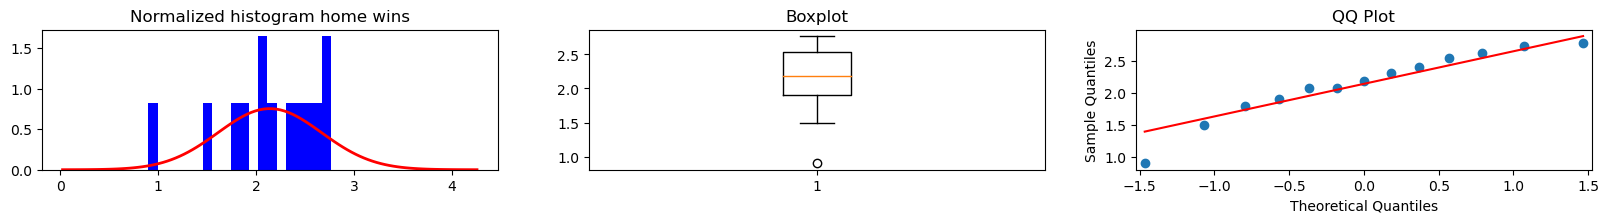

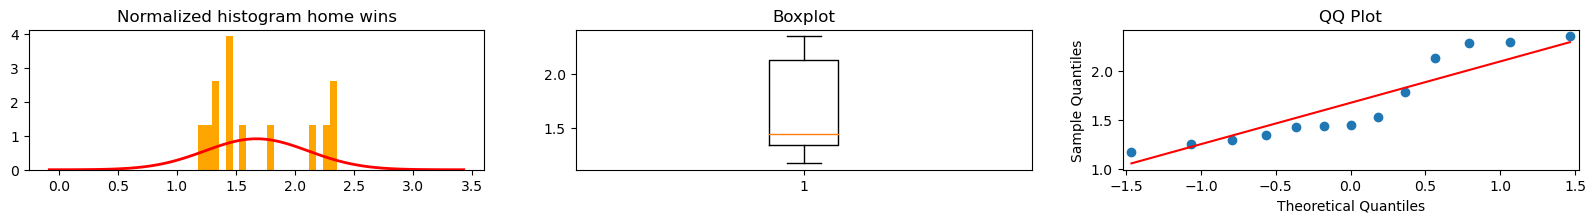

SW Statistic: 0.9272053837776184 	 p-value: 0.3131621778011322
SW Statistic: 0.8428726196289062 	 p-value: 0.023066462948918343


In [47]:
visual_normality_test(np.array(WIN_RATE_NORMAL), 'blue')
sw_statistic, p_value = shapiro(np.array(WIN_RATE_NORMAL))   #HO: FOLLOWS A NORMAL DISTRIBUTION H1: DIFFERENT THAN NORMAL DISTRIBUTION
visual_normality_test(np.array(WIN_RATE_CHAMPIONS), 'orange')
sw_statistic1, p_value1 = shapiro(np.array(WIN_RATE_CHAMPIONS))
print('SW Statistic:', sw_statistic, '\t p-value:', p_value)
print('SW Statistic:', sw_statistic1, '\t p-value:', p_value1)

FROM THIS WE GET THAT THE NORMAL PREMIER GAMES FOLLOW A NORMAL DISTRIBUTION WHILE CHAMPIONS PREMIER GAMES DO NOT

In [48]:
teams = EURO_TEAMS + EURO_TEAMS2

print(WIN_RATE_NORMAL)
print(WIN_RATE_CHAMPIONS)

[1.8, 2.769230769230769, 2.727272727272727, 2.4, 2.1818181818181817, 1.9090909090909092, 1.5, 2.3076923076923075, 2.076923076923077, 0.9, 2.076923076923077, 2.625, 2.5384615384615383]
[1.3478260869565217, 2.28, 2.2962962962962963, 1.7857142857142858, 1.4375, 1.2962962962962963, 1.25, 2.3529411764705883, 1.1764705882352942, 1.4285714285714286, 1.4444444444444444, 2.1333333333333333, 1.5294117647058822]


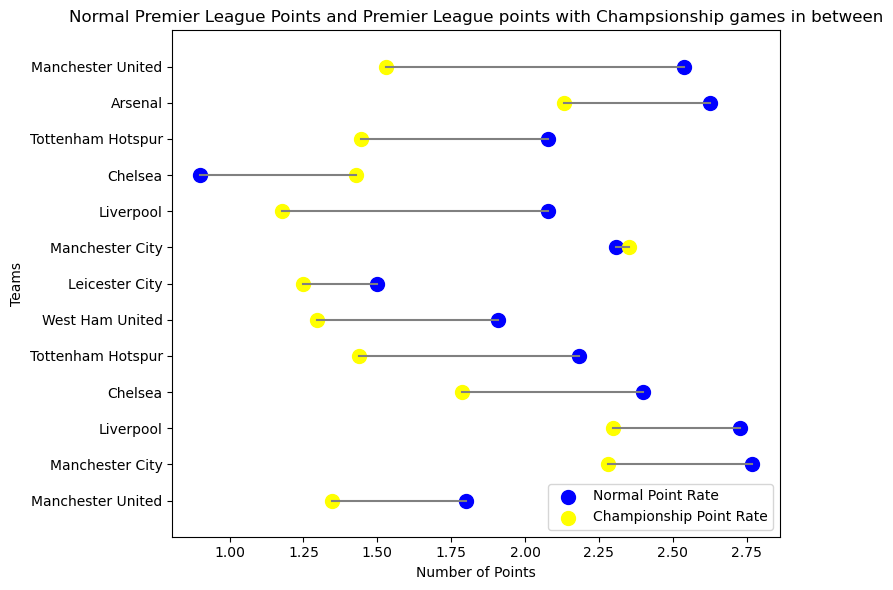

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
teams = EURO_TEAMS + EURO_TEAMS2
normal_rate = WIN_RATE_NORMAL
championship_rate = WIN_RATE_CHAMPIONS

# Set figure size
fig, ax = plt.subplots(figsize=(8, 6))

# Set y-axis limits
ax.set_ylim(-1, len(teams))

# Plot lollipop markers for home points
ax.scatter(normal_rate, range(len(teams)), color='blue', marker='o', s=100, label='Normal Point Rate')

# Plot lollipop markers for away points
ax.scatter(championship_rate, range(len(teams)), color='yellow', marker='o', s=100, label='Championship Point Rate')

# Plot lines connecting home and away points
for i in range(len(teams)):
    ax.plot([normal_rate[i], championship_rate[i]], [i, i], color='gray')

# Set y-axis tick labels
ax.set_yticks(range(len(teams)))
ax.set_yticklabels(teams)

# Set labels and title
ax.set_xlabel('Number of Points')
ax.set_ylabel('Teams')
ax.set_title('Normal Premier League Points and Premier League points with Champsionship games in between')

# Set legend
ax.legend()

# Adjust layout
plt.tight_layout()

# Show the graph
plt.show()


THIS FIGURE REPRESENTS THE RATIO OF POINTS WON IN NORMAL LEAGUE GAMES AND THE RATIO OF POINTS WON IN LEAGUE GAMES WITH CHAMPIONSHIPS GAMES IN BETWEEN

DUE TO ONE SAMPLE BEING NORMALLY DISTRIBUTED AND THE OTHER NOT, WE HAVE DECIDED TO TRY BOTH A NON PARAMETRIC TEST (WILCOXON SIGNED RANK TEST)
AND A PARAMETRIC TEST (T-TEST)

IN BOTH CASES WE ARRIVED TO THE SAME CONCLUSION
HO: NO DIFFERENCE IN POINTS.    H1:THERE IS A DIFFERENCE IN POINTS.

## Wilcoxon Signed Ranked Test

In [50]:
def wilcoxon_signed_rank_test(sample1, sample2):
    t, p_value = wilcoxon(sample1, sample2, zero_method='wilcox', correction=True)
    alpha = 0.05
    return p_value
sample1 = np.array(WIN_RATE_NORMAL)
sample2 = np.array(WIN_RATE_CHAMPIONS)

p_value = wilcoxon_signed_rank_test(sample1, sample2)
print(f"p-value: {p_value}")
if p_value < 0.05:
    print("We reject the null hypothesis H0")
else:
    print('We accept the null hypothesis H0')

p-value: 0.006103515625
We reject the null hypothesis H0


## Paired t-test ##

In [51]:
def t_test(sample1, sample2):
    diff =  np.array(sample1)- np.array(sample2)
    u_diff = diff.mean()

    n = len(diff)

    t_statistic = diff.mean()/sem(diff)
    p_value = 2*t(df=n-1).cdf(-np.abs(t_statistic))
    return t_statistic, p_value

t_statistic,p_value = t_test(WIN_RATE_NORMAL,WIN_RATE_CHAMPIONS)
print(t_statistic, p_value)
if p_value < 0.05:
    print('We reject the null hypothesis H0')
else:
    print('We accept the null hypothesis H0')

4.1841661620259245 0.0012670813117330944
We reject the null hypothesis H0


AS CONCLUSION WE REJECT THE NULL HYPOTHESIS H0 ---> INTERNATIONAL GAMES AFFECT THE PERFORMANCE OF NATIONAL TEAMS

## 3) Linear Regression: Attack or Defense? ##

### Exploratory Analysis and Normality Test ##

C:\Users\Javito\AppData\Local\Temp\ipykernel_10624\412731720.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.zeros_like(df_stats1[feature_names].corr(), dtype=np.bool)
C:\Users\Javito\AppData\Local\Temp\ipykernel_10624\412731720.py:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df_stats1[feature_names].corr(), dtype=np.bool)
C:\Users\Javito\AppData\Local\Temp\ipykernel_10624\412731720.py:24: FutureWarning: The default value of numeric_only in DataFrame.corr i

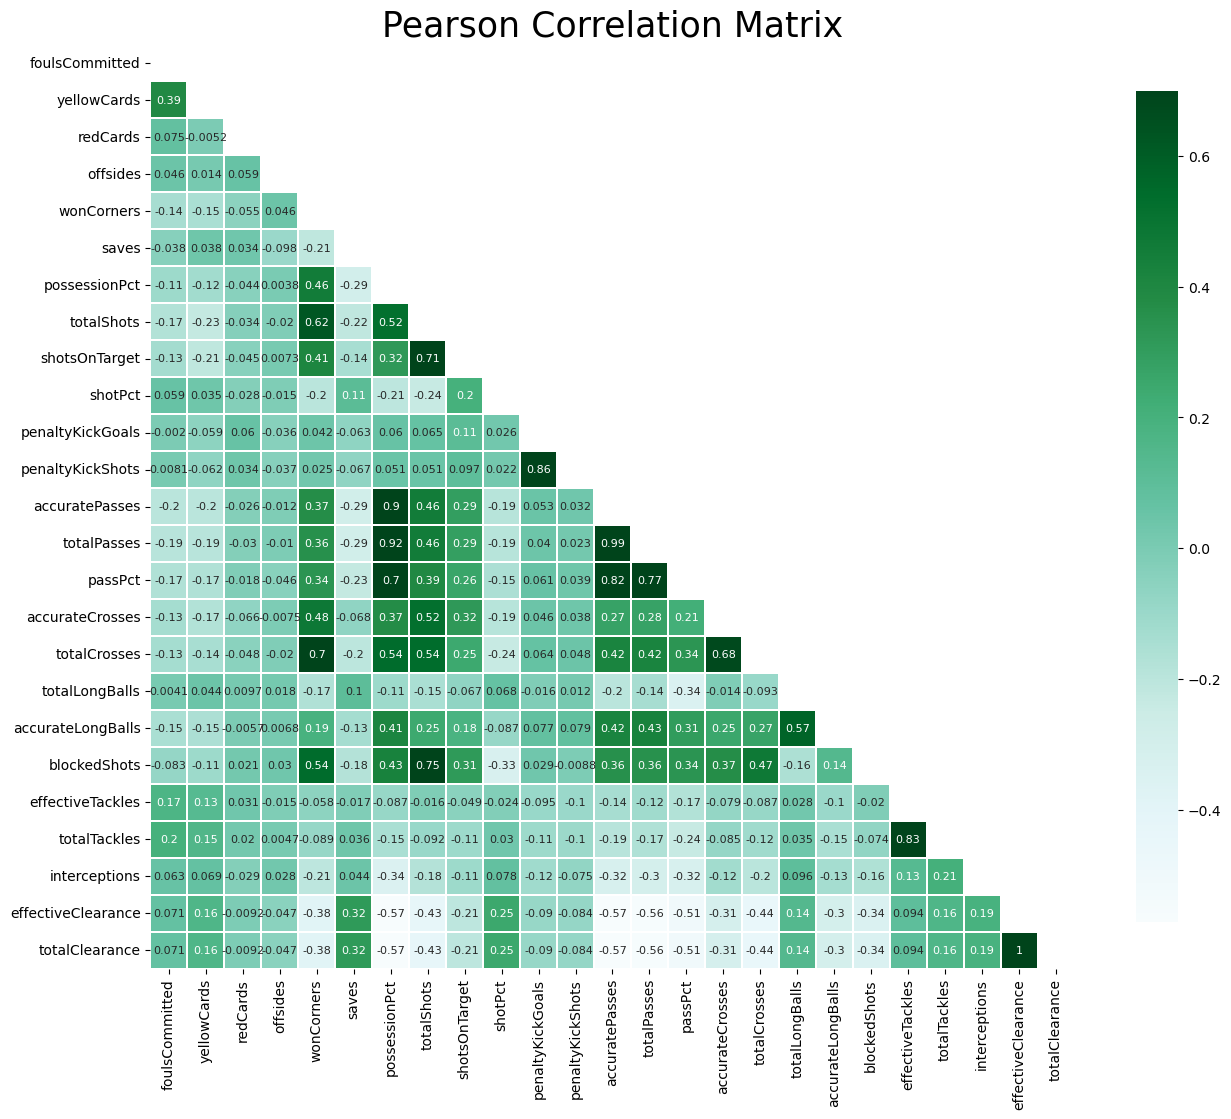

In [52]:
df_stats1 = pd.read_csv('./projectdata/PREMIER_LEAGUE_STATS.csv')   #THIS WILL BE USED FOR A PEARSON CORRELATION MATRIX
#MORE STATS ARE AVAILABE IN THIS DATASET
#print(df_stats.columns.values)
#print(df_stats)
df_stats1['possessionPct'] = df_stats1['possessionPct'].str.rstrip('%').astype('float')
df_stats1['passPct'] = df_stats1['passPct'].str.rstrip('%').astype('float')
df_stats1.columns = df_stats1.columns.str.replace('Hom Team', 'Home Team')

feature_names = ['foulsCommitted', 'yellowCards',
 'redCards','offsides' ,'wonCorners' ,'saves' ,'possessionPct', 'totalShots',
 'shotsOnTarget', 'shotPct' ,'penaltyKickGoals', 'penaltyKickShots', 
 'accuratePasses', 'totalPasses',  'passPct',  'accurateCrosses',  'totalCrosses',
 'crossPct',  'totalLongBalls',  'accurateLongBalls' , 'longballPct',
 'blockedShots',  'effectiveTackles',  'totalTackles',  'tacklePct',
 'interceptions',  'effectiveClearance', 'totalClearance']
#feature_names = ["Possession Pct","Fouls Committed","Yellow Cards","Red Cards","Offsides","Corners Won","Saves","Total Shots","Shots on Target"]

mask = np.zeros_like(df_stats1[feature_names].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df_stats1[feature_names].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});


In [53]:
# pandas vs plotly
import plotly.express as px
def scatter_plot(x_variable, y_variable,df):
    #pandas
    df.plot.scatter(x=x_variable,y=y_variable,alpha=0.2)
    plt.show()
    plt.figure(figsize=(100,30))

    #plotly
    fig = px.scatter(df, x=x_variable, y=y_variable,
                     marginal_y="histogram", marginal_x="histogram",
                     height=400, template = 'plotly_white')
    fig.show()
#scatter_plot('Goals_scored', 'possessionPct')


In [54]:
# Sample data

# Create a constant term to fit the intercept in the linear regression
def linear_regression_hypothesis(sample1, sample2):
    X = sm.add_constant(sample1)

    # Fit the linear regression model
    model = sm.OLS(sample2, X)
    results = model.fit()
    print(results.summary())

    # Extract the coefficients from the results
    intercept, slope = results.params 

    # Print the regression results
    #print(f"Intercept: {intercept}")
    #print(f"Slope: {slope}")
    #print(f"R-squared: {results.rsquared}")
    #print(results)
    y_hat = results.predict(X)
    plt.scatter(sample1,sample2,alpha=0.1)
    plt.plot(sample1,y_hat,'r')
    plt.show()

    # Hypothesis testing
    t_value = slope / results.bse[1]  # Calculate the t-value
    p_value = results.pvalues[1]  # Get the p-value
    
    return p_value, t_value , slope

------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     168.7
Date:                Fri, 26 May 2023   Prob (F-statistic):           1.39e-10
Time:                        21:15:08   Log-Likelihood:                -63.722
No. Observations:                  20   AIC:                             131.4
Df Residuals:                      18   BIC:                             133.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

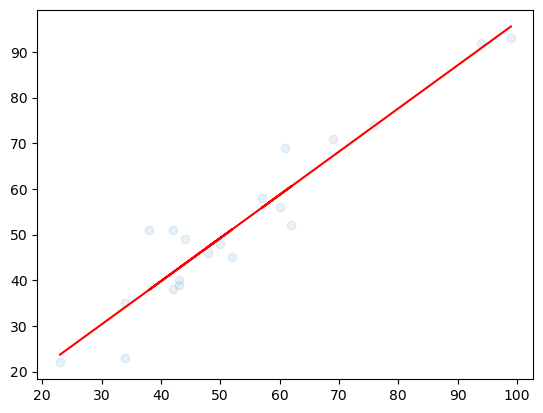

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     65.50
Date:                Fri, 26 May 2023   Prob (F-statistic):           2.08e-07
Time:                        21:15:08   Log-Likelihood:                -71.770
No. Observations:                  20   AIC:                             147.5
Df Residuals:                      18   BIC:                             149.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        109.1552      7.286     14.981      0.0

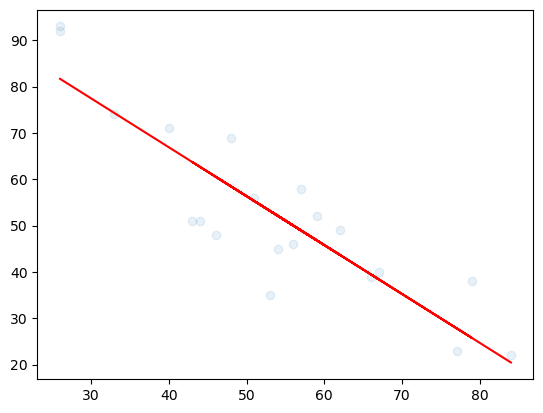

0.9452714870775072 -1.0561193373259081
Reject the null hypothesis (H0). There is linear dependence.There is a relation between scored goals and points obtained
Reject the null hypothesis (H0). There is linear dependence. There is a relation between received goals and points obtained
DEFENSE IS MORE IMPORTANT THAN ATTACK


In [55]:
df_regression = pd.read_csv('./projectdata/LEAGUE_TABLE_2021_2022.csv')   #PART OF SEASON 2021-2022 DATABASE
x = df_regression["GF"]   #WE GET THE FAVOR GOALS OF EVERY TEAM
x1 = df_regression["GA"]  #WE GET THE AGAINST GOALS OF EVERY TEAM
y = df_regression["Points"]  #WE GET THE POINTS OBTAINED BY EVERY TEAM DURING THE SEASON
#WE PERFORM THE LINEAR REGRESSION ANALYSIS BY USING THE FUNCTIONS ABOVE
#scatter_plot("GF", "Points", df_regression)
print("------------------------------------------------------")
#scatter_plot("GA", "Points", df_regression)
alpha = 0.05  # Significance level
p_value, t_value, slope = linear_regression_hypothesis(x,y)
p_value1, t_value1, slope1 = linear_regression_hypothesis(x1,y)
print(slope, slope1)
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0). There is linear dependence.There is a relation between scored goals and points obtained")
else:
    print("Fail to reject the null hypothesis (H0). There is no linear dependence.")
if p_value1 < alpha:
    print("Reject the null hypothesis (H0). There is linear dependence. There is a relation between received goals and points obtained")
else:
    print("Fail to reject the null hypothesis (H0). There is no linear dependence.")

if np.abs(slope) > np.abs(slope1):
    print("THE ATTACK IS MORE IMPORTANT THAN DEFENSE")
else:
    print("DEFENSE IS MORE IMPORTANT THAN ATTACK")
    

Therefore, we have here tested that:
- GF AND POINTS AND GA AND POINTS HAVE LINEAR DEPENDANCE---> B1 !=0
- SINCE THE SLOPE IN GA IN HIGHER WE DETERMINE THAT DEFENSE IS MORE IMPORTANT THAN OFFENSE

NOW WE WILL ALSO TRY TO TEST WHETHER POSSESION AND POINTS HAVE LINEAR RELATION
- H0: POSSESION AND POINTS ARE NOT LINEALY RELATED
- H1: POSSESION AND POINTS ARE LINEARLY RELATED

In [56]:
PL_TEAMS = ["Manchester City", "Liverpool","Chelsea","Tottenham Hotspur",
"Arsenal",
"Manchester United",
"West Ham United",
"Leicester City",
"Brighton & Hove Albion",
"Wolverhampton Wanderers",
"Newcastle United",
"Crystal Palace",
"Brentford",
"Aston Villa",
"Southampton",
"Everton",
"Leeds United",
"Burnley",
"Watford",
"Norwich City"
]
#WE GET THE MID POSSESION OF EACH TEAM BY ANALYZING THE POSSESION OBTAINED IN EACH GAME
#print(PL_TEAMS)
df_stats = pd.read_csv("./projectdata/STATS_2021-2022.csv")  #DATA FROM SEASON 2021-2022

#print(df_stats)
mean_possesion = []
for team in PL_TEAMS:
    aux_list = []
    for i in range(len(df_stats)):
        data = df_stats
        Team = data.iloc[i]["Team"]
        Possesion = data.iloc[i]["Possession Pct"]
        if Team == team:
            aux_list.append(Possesion)
        else:
            pass
    mean_possesion.append(np.mean(aux_list))
print(mean_possesion)

[68.29736842105264, 63.17894736842107, 62.20526315789473, 51.8578947368421, 52.96315789473685, 52.73684210526316, 47.72368421052631, 52.15789473684211, 54.550000000000004, 49.53684210526316, 40.01842105263157, 51.16842105263158, 44.568421052631585, 46.43947368421053, 47.75263157894736, 39.70789473684211, 52.51578947368421, 39.72894736842106, 40.32631578947368, 42.56578947368421]


In [19]:
aux_df = {"Possesion": mean_possesion}
#print(aux_df)

                            OLS Regression Results                            
Dep. Variable:                 Points   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     48.94
Date:                Fri, 26 May 2023   Prob (F-statistic):           1.57e-06
Time:                        21:01:38   Log-Likelihood:                -73.981
No. Observations:                  20   AIC:                             152.0
Df Residuals:                      18   BIC:                             154.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -50.4983     14.916     -3.385      0.0

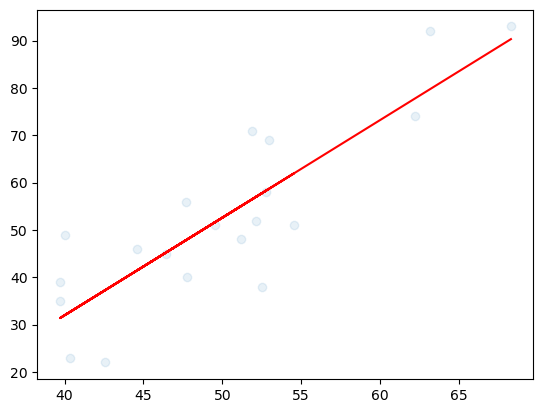

1.566008643733595e-06
WE REJECT H0 AT 5% CONFIDENCE LEVEL


In [20]:
p_value, t_value, slope = linear_regression_hypothesis(aux_df["Possesion"],df_regression["Points"])
print(p_value)
alpha = 0.05
if p_value < alpha:
    print("WE REJECT H0 AT 5% CONFIDENCE LEVEL")
else:
    print("WE FAIL TO REJECT H0 AT 5% CONFIDENCE LEVEL")

THANKS TO THIS WE ENDED UP CONCLUDING THAT POSSESION PCT AND THE POINTS YOU OBTAINED IN THE LEAGUE ARE LINEARLY DEPENDENT.